In [2]:
## Practical 1: word2vec
Oxford CS - Deep NLP 2017<br>
https://www.cs.ox.ac.uk/teaching/courses/2016-2017/dl/

SyntaxError: invalid syntax (<ipython-input-2-6a83261dba46>, line 2)

This practical is presented as an IPython Notebook, with the code written for recent versions of **Python 3**. The code in this practical will not work with Python 2 unless you modify it. If you are using your own Python installation, ensure you have a setup identical to that described in the installation shell script (which is intended for use with the department lab machines). We will be unable to support installation on personal machines due to time constraints, so please use the lab machines and the setup script if you are unfamiliar with how to install Anaconda.

To execute a notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

In [1]:
import numpy as np
import os
from random import shuffle
import re
from collections import Counter
import sklearn as sk

In [3]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Part 0: Download the TED dataset

In [5]:
import urllib.request
import zipfile
import lxml.etree

In [6]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [52]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))
del doc

In [53]:
np.size(input_text)

1

### Part 1: Preprocessing

In this part, we attempt to clean up the raw subtitles a bit, so that we get only sentences. The following substring shows examples of what we're trying to get rid of. Since it's hard to define precisely what we want to get rid of, we'll just use some simple heuristics.

In [8]:
i = input_text.find("Hyowon Gweon: See this?")
input_text[i-20:i+150]

' baby does.\n(Video) Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.\nLaura Schulz: Told you. (Laughs)\n(Vide'

Let's start by removing all parenthesized strings using a regex:

In [9]:
input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)

We can verify the same location in the text is now clean as follows. We won't worry about the irregular spaces since we'll later split the text into sentences and tokenize it anyway.

In [10]:
i = input_text_noparens.find("Hyowon Gweon: See this?")
input_text_noparens[i-20:i+150]

"hat the baby does.\n Hyowon Gweon: See this?  Did you see that?  Cool. See this one?  Wow.\nLaura Schulz: Told you. \n HG: See this one?  Hey Clara, this one's for you. You "

Now, let's attempt to remove speakers' names that occur at the beginning of a line, by deleting pieces of the form "`<up to 20 characters>:`", as shown in this example. Of course, this is an imperfect heuristic. 

In [11]:
sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)

# Uncomment if you need to save some RAM: these strings are about 50MB.
# del input_text, input_text_noparens

# Let's view the first few:
sentences_strings_ted[:5]

["Here are two reasons companies fail: they only do more of the same, or they only do what's new",
 'To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation',
 ' Both are necessary, but it can be too much of a good thing',
 'Consider Facit',
 " I'm actually old enough to remember them"]

Now that we have sentences, we're ready to tokenize each of them into words. This tokenization is imperfect, of course. For instance, how many tokens is "can't", and where/how do we split it? We'll take the simplest naive approach of splitting on spaces. Before splitting, we remove non-alphanumeric characters, such as punctuation. You may want to consider the following question: why do we replace these characters with spaces rather than deleting them? Think of a case where this yields a different answer.

In [12]:
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)

Two sample processed sentences:

In [13]:
len(sentences_ted)

266694

In [14]:
print(sentences_ted[0])
print(sentences_ted[1])

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']


### Part 2: Word Frequencies

If you store the counts of the top 1000 words in a list called `counts_ted_top1000`, the code below will plot the histogram requested in the writeup.

In [15]:
WC = {}

l = len(sentences_ted)

for i in range(l):
    sl = len(sentences_ted[i])
    for j in range(sl):
        if sentences_ted[i][j] in WC:
            WC[sentences_ted[i][j]] += 1
        else:
            WC[sentences_ted[i][j]] = 1       

In [16]:
d = Counter(WC).most_common(1000)

counts_ted_top1000 = [None] * len(d)
for i in range(len(d)):
    counts_ted_top1000[i] = d[i][1]

Plot distribution of top-1000 words

In [17]:
hist, edges = np.histogram(counts_ted_top1000, density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Top-1000 words distribution")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

### Part 3: Train Word2Vec

In [18]:
from gensim.models import Word2Vec

In [19]:
model_ted = Word2Vec(sentences_ted, min_count=10)

In [20]:
print(len(model_ted.vocab))

14427


### Part 4: Ted Learnt Representations

Finding similar words: (see gensim docs for more functionality of `most_similar`)

In [21]:
model_ted.most_similar("man")

[('woman', 0.8645023703575134),
 ('guy', 0.8013980388641357),
 ('lady', 0.7564507722854614),
 ('boy', 0.7517989873886108),
 ('gentleman', 0.7314210534095764),
 ('girl', 0.7280215620994568),
 ('soldier', 0.7279913425445557),
 ('surgeon', 0.6753103733062744),
 ('kid', 0.6674375534057617),
 ('poet', 0.6671075224876404)]

In [22]:
model_ted.most_similar("computer")

[('machine', 0.7457113862037659),
 ('software', 0.7199077606201172),
 ('device', 0.714401125907898),
 ('robot', 0.708403468132019),
 ('printer', 0.6558226346969604),
 ('chip', 0.6461496949195862),
 ('camera', 0.644477367401123),
 ('program', 0.6395647525787354),
 ('3d', 0.6327172517776489),
 ('simulation', 0.6199120879173279)]

In [23]:
model_ted.most_similar("gun")

[('knife', 0.6820816993713379),
 ('officer', 0.6762154698371887),
 ('driver', 0.6687833666801453),
 ('horse', 0.6658897399902344),
 ('chief', 0.6610320806503296),
 ('army', 0.6607373952865601),
 ('department', 0.6471673846244812),
 ('soldier', 0.6469913125038147),
 ('owner', 0.6416589617729187),
 ('truck', 0.6412670016288757)]

In [24]:
model_ted.most_similar("religion")

[('islam', 0.7859427332878113),
 ('politics', 0.75954669713974),
 ('belief', 0.7326904535293579),
 ('equality', 0.7068684101104736),
 ('religious', 0.7004959583282471),
 ('culture', 0.6913602352142334),
 ('gender', 0.6836018562316895),
 ('compassion', 0.677335798740387),
 ('violence', 0.6676831245422363),
 ('status', 0.6618347764015198)]

In [25]:
model_ted.most_similar("bug")

[('fork', 0.6957576870918274),
 ('melody', 0.6878770589828491),
 ('dolphin', 0.6723216772079468),
 ('matt', 0.6550450325012207),
 ('predator', 0.653942883014679),
 ('limp', 0.6420696973800659),
 ('spear', 0.6371723413467407),
 ('bunny', 0.6366810202598572),
 ('mounted', 0.634685754776001),
 ('crane', 0.6346005797386169)]

In [26]:
model_ted.most_similar("poverty")

[('violence', 0.7553958892822266),
 ('corruption', 0.7259977459907532),
 ('conflict', 0.7104753851890564),
 ('terrorism', 0.6900291442871094),
 ('employment', 0.6776536107063293),
 ('crime', 0.6653692722320557),
 ('refugees', 0.6626020073890686),
 ('workforce', 0.6606540679931641),
 ('politics', 0.6517866253852844),
 ('discrimination', 0.6471254229545593)]

#### t-SNE visualization
To use the t-SNE code below, first put a list of the top 1000 words (as strings) into a variable `words_top_ted`. The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [27]:
words_top_ted = [None] * len(d)
for i in range(len(d)):
    words_top_ted[i] = d[i][0]

# This assumes words_top_ted is a list of strings, the top 1000 words
words_top_vec_ted = model_ted[words_top_ted]

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [29]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Interesitng example can be seen above where the cluster clearly contains words used for comparison. While words ending in "er" could be expected to be classified toghether due to their common suffix, the algorithm has also successfully clustered in "more" and "less" based on the common neighbours.

In [30]:
model_ted.similarity('car', 'bicycle')

0.60563246034446616

In [31]:
car = model_ted['car']
bicycle = model_ted['bicycle']

np.dot(car, bicycle)/(np.linalg.norm(car)*np.linalg.norm(bicycle))

0.60563248

As it can be seen the similarity measure of the model and the cosine distance are exactly the same.

### Part 5: Wiki Learnt Representations

Download dataset

In [32]:
if not os.path.isfile('wikitext-103-raw-v1.zip'):
    urllib.request.urlretrieve("https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip", filename="wikitext-103-raw-v1.zip")

In [33]:
with zipfile.ZipFile('wikitext-103-raw-v1.zip', 'r') as z:
    input_text = str(z.open('wikitext-103-raw/wiki.train.raw', 'r').read())

Preprocess sentences (note that it's important to remove small sentences for performance)

In [34]:
sentences_wiki = []
for line in input_text.split('\n'):
    s = [x for x in line.split('.') if x and len(x.split()) >= 5]
    sentences_wiki.extend(s)
    
for s_i in range(len(sentences_wiki)):
    sentences_wiki[s_i] = re.sub("[^a-z]", " ", sentences_wiki[s_i].lower())
    sentences_wiki[s_i] = re.sub(r'\([^)]*\)', '', sentences_wiki[s_i])
del input_text

In [35]:
# sample 1/5 of the data
shuffle(sentences_wiki)
print(len(sentences_wiki))
sentences_wiki = sentences_wiki[:int(len(sentences_wiki)/5)]
print(len(sentences_wiki))

3902491
780498


Now, repeat all the same steps that you performed above. You should be able to reuse essentially all the code.

In [36]:
sentences_wiki_tok = []
for sent_str in sentences_wiki:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_wiki_tok.append(tokens)

In [37]:
print(sentences_wiki_tok[1])

['n', 'n', 'antitumor', 'properties', 'n', 'n', 'research', 'conducted', 'in', 'suggests', 'that', 'extracts', 'from', 'polyozellus', 'multiplex', 'may', 'have', 'suppressive', 'effects', 'on', 'stomach', 'cancer']


In [38]:
WCw = {}

lw = len(sentences_wiki_tok)

for i in range(lw):
    sl = len(sentences_wiki_tok[i])
    for j in range(sl):
        if sentences_wiki_tok[i][j] in WCw:
            WCw[sentences_wiki_tok[i][j]] += 1
        else:
            WCw[sentences_wiki_tok[i][j]] = 1       

In [39]:
dw = Counter(WCw).most_common(1000)

In [40]:
model_wiki = Word2Vec(sentences_wiki_tok, min_count=10)

In [41]:
print(len(model_wiki.vocab))

48893


In [42]:
model_wiki.most_similar("chicken")

[('fried', 0.8737301826477051),
 ('sauce', 0.8504369258880615),
 ('potato', 0.8235470652580261),
 ('cheese', 0.8227880597114563),
 ('steak', 0.8113231062889099),
 ('beef', 0.8104126453399658),
 ('onions', 0.808318555355072),
 ('beans', 0.7983804941177368),
 ('pork', 0.7913760542869568),
 ('tomato', 0.7893295884132385)]

In [43]:
model_wiki.most_similar("beef")

[('pork', 0.8989481925964355),
 ('vegetables', 0.867498517036438),
 ('meat', 0.8623645901679993),
 ('butter', 0.8610756397247314),
 ('potatoes', 0.8494815230369568),
 ('spices', 0.8425906896591187),
 ('beans', 0.8400148153305054),
 ('dried', 0.8358799815177917),
 ('cheese', 0.8328332304954529),
 ('salted', 0.8305286765098572)]

In [44]:
model_wiki.most_similar("pork")

[('beef', 0.8989483118057251),
 ('beans', 0.8678421974182129),
 ('butter', 0.8673344254493713),
 ('vegetables', 0.8629944324493408),
 ('potatoes', 0.8441775441169739),
 ('salted', 0.8238231539726257),
 ('onions', 0.8178487420082092),
 ('garlic', 0.8150165677070618),
 ('fried', 0.8108026385307312),
 ('meat', 0.8103172779083252)]

In [45]:
words_top_wiki = [None] * len(dw)
for i in range(len(dw)):
    words_top_wiki[i] = dw[i][0]

words_top_vec_ted = model_ted[words_top_ted]

#### t-SNE visualization

In [46]:
# This assumes words_top_ted is a list of strings, the top 1000 words
words_top_vec_wiki = model_wiki[words_top_wiki]

tsne = TSNE(n_components=2, random_state=0)
words_top_wiki_tsne = tsne.fit_transform(words_top_vec_wiki)

In [47]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_wiki_tsne[:,0],
                                    x2=words_top_wiki_tsne[:,1],
                                    names=words_top_wiki))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Intereseing 2 clusters can be seen above. One contains the modal verbs while the other contains month names. However since "may" can be both the month name and the verb it is clear from the cluster that it appears as a verb more often, and it could be that these 2 clusters are so close exactly because of the word "may". It also shows that it might not be a good idea to convert all words into lower case because they lose the context.

Notable difference between embeddings come form the fact that TED dataset is based on spoken language and WIKI dataset is based on written articles. Due to this TED dataset will tend to cluster words together in a more "talkative" way, especially given the nonchalante nature of TED talks, while the WIKI embedings will follow stricter grammar rules as well as the problem of classifying abbrevations and formulas in a strange way.

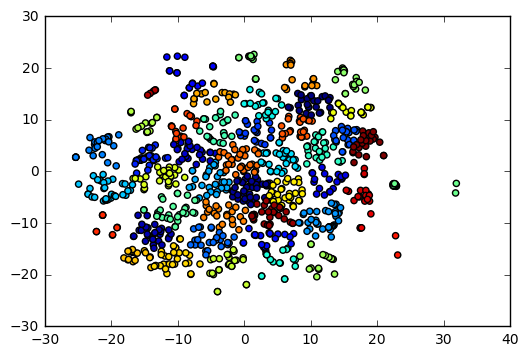

In [49]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from sklearn.datasets import load_iris
import pylab as pl

k=45

kmeans = KMeans(n_clusters=k, random_state=111)
kmeans.fit(words_top_wiki_tsne)
pl.figure('K-means')
pl.scatter(words_top_wiki_tsne[:, 0], words_top_wiki_tsne[:, 1], c=kmeans.labels_)
pl.show()

In [50]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_wiki_tsne[:,0],
                                    x2=words_top_wiki_tsne[:,1],
                                    names=words_top_wiki,
                                    clust=kmeans.labels_))

p.scatter(x='x1', y='x2', color='clust', size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)